In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
import copy

### Učitavanje podataka

In [2]:
# ucitavanje podataka
X = pd.read_csv("../heart_disease_uci.csv")

In [3]:
X

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,916,54,Female,VA Long Beach,asymptomatic,127.0,333.0,True,st-t abnormality,154.0,False,0.0,NaN,NaN,NaN,1
916,917,62,Male,VA Long Beach,typical angina,NaN,139.0,False,st-t abnormality,NaN,NaN,NaN,NaN,NaN,NaN,0
917,918,55,Male,VA Long Beach,asymptomatic,122.0,223.0,True,st-t abnormality,100.0,False,0.0,NaN,NaN,fixed defect,2
918,919,58,Male,VA Long Beach,asymptomatic,NaN,385.0,True,lv hypertrophy,NaN,NaN,NaN,NaN,NaN,NaN,0


### Početni pregled podataka

In [4]:
#imamo 16 značajki te 920 unosa u datasetu
X.shape

(920, 16)

In [5]:
print(X.columns.values)
print(X.num.unique())

['id' 'age' 'sex' 'dataset' 'cp' 'trestbps' 'chol' 'fbs' 'restecg'
 'thalch' 'exang' 'oldpeak' 'slope' 'ca' 'thal' 'num']
[0 2 1 3 4]


### Značenje značajki

* __id__ - jedinstveni identifikator
* __age__ - broj godina pacijenta 
* __sex__ - spol pacijenta (M za muškarca i Ž za ženu)
* __dataset__ - pripadnost datasetu (Cleveland, Hungary, Switzerland, VA Long Beach)
* __cp__ - vrsta boli u prsima
* __trestbps__ - krvni tlak 
* __chol__ - razina kolesterola  
* __fbs__ - razina šećera u krvi natašte (1 ako više 120mg/dl, 0 inače)
* __restecg__ - kategorija EKG-a (elektrokardiogram) pri mirovanju (lv-hypertrophy, normal, st-t abnormality)
* __thalch__ - maksimalna brzina otkucaja srca 
* __exang__ - angina uzrokovana fizičkim naporom(vježbanjem); 1 ako da, inače 0
* __oldpeak__ - status depresije kod pacijenta; interval (0, 6.2)
* __slope__ - nagib ST segmenta pri vrhuncu vježbanja
* __ca__ - broj glavnih žila obojanih flouroskopijom; interval [0,3]
* __thal__ - tip talasemije (poremećaj krvi - nedostatak hemoglobina)
* __num__ - ima li pacijent srčanu bolest ili ne (0-sigurno ne, 4-sigurno da te 1,2 i 3 kao međuvrijednosti)

### Monotoni atributi

In [6]:
#idemo vidjeti koji su to atributi monotoni, odnosno koji su to atributi jedinstveni za svaki primjer 
#očekivano to je id 
#monotone atribute mičemo iz dataseta (osim ako se radi o vremenskim id atributima)
X.nunique()

id          920
age          50
sex           2
dataset       4
cp            4
trestbps     61
chol        217
fbs           2
restecg       3
thalch      119
exang         2
oldpeak      53
slope         3
ca            4
thal          3
num           5
dtype: int64

`Riješit ćemo se atributa id jer je monoton. `

In [7]:
X.drop(('id'), axis=1, inplace=True)

In [8]:
X

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,Female,VA Long Beach,asymptomatic,127.0,333.0,True,st-t abnormality,154.0,False,0.0,NaN,NaN,NaN,1
916,62,Male,VA Long Beach,typical angina,NaN,139.0,False,st-t abnormality,NaN,NaN,NaN,NaN,NaN,NaN,0
917,55,Male,VA Long Beach,asymptomatic,122.0,223.0,True,st-t abnormality,100.0,False,0.0,NaN,NaN,fixed defect,2
918,58,Male,VA Long Beach,asymptomatic,NaN,385.0,True,lv hypertrophy,NaN,NaN,NaN,NaN,NaN,NaN,0


### Nedostajući podaci

In [9]:
print("broj NaN vrijednosti za svaku značajku: \n")
print(X.isna().sum())

broj NaN vrijednosti za svaku značajku: 

age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64


`Izbacit ćemo 2 zapisa gdje je restecg NaN.`

In [10]:
X = X.loc[X.restecg.notnull(), :]
X

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,Female,VA Long Beach,asymptomatic,127.0,333.0,True,st-t abnormality,154.0,False,0.0,NaN,NaN,NaN,1
916,62,Male,VA Long Beach,typical angina,NaN,139.0,False,st-t abnormality,NaN,NaN,NaN,NaN,NaN,NaN,0
917,55,Male,VA Long Beach,asymptomatic,122.0,223.0,True,st-t abnormality,100.0,False,0.0,NaN,NaN,fixed defect,2
918,58,Male,VA Long Beach,asymptomatic,NaN,385.0,True,lv hypertrophy,NaN,NaN,NaN,NaN,NaN,NaN,0


`Izbacit ćemo značajke ca, thal i slope koje su NaN za redom ~66%, ~53% i ~34% primjera s time da su zadnje 2 značajke još i kategoričke.`
`Značajke chol, trestbps, thalch i oldpeak dopunit ćemo prosječnom vrijednošću.`

In [11]:
X2=X.copy()
X2.drop(['ca', 'thal', 'slope'], axis=1, inplace=True)
X2.loc[X2.chol.isna(),'chol'] = X2.loc[:,'chol'].mean()
X2.loc[X2.trestbps.isna(),'trestbps'] = X2.loc[:,'trestbps'].mean()
X2.loc[X2.thalch.isna(),'thalch'] = X2.loc[:,'thalch'].mean()
X2.loc[X2.oldpeak.isna(),'oldpeak'] = X2.loc[:,'oldpeak'].mean()
X2

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,num
0,63,Male,Cleveland,typical angina,145.00000,233.0,True,lv hypertrophy,150.000000,False,2.300000,0
1,67,Male,Cleveland,asymptomatic,160.00000,286.0,False,lv hypertrophy,108.000000,True,1.500000,2
2,67,Male,Cleveland,asymptomatic,120.00000,229.0,False,lv hypertrophy,129.000000,True,2.600000,1
3,37,Male,Cleveland,non-anginal,130.00000,250.0,False,normal,187.000000,False,3.500000,0
4,41,Female,Cleveland,atypical angina,130.00000,204.0,False,lv hypertrophy,172.000000,False,1.400000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
915,54,Female,VA Long Beach,asymptomatic,127.00000,333.0,True,st-t abnormality,154.000000,False,0.000000,1
916,62,Male,VA Long Beach,typical angina,132.14319,139.0,False,st-t abnormality,137.528389,NaN,0.880607,0
917,55,Male,VA Long Beach,asymptomatic,122.00000,223.0,True,st-t abnormality,100.000000,False,0.000000,2
918,58,Male,VA Long Beach,asymptomatic,132.14319,385.0,True,lv hypertrophy,137.528389,NaN,0.880607,0


In [12]:
print("broj NaN vrijednosti za svaku značajku: \n")
print(X2.isna().sum())

broj NaN vrijednosti za svaku značajku: 

age          0
sex          0
dataset      0
cp           0
trestbps     0
chol         0
fbs         89
restecg      0
thalch       0
exang       55
oldpeak      0
num          0
dtype: int64


`Izbaci retke u kojima su fbs ili exang jednaki NaN.`

In [13]:
X3 = X2.loc[X2.fbs.notnull(), :]
X4 = X3.loc[X3.exang.notnull(), :]

### Stršeći podaci

In [14]:
X4.describe()

,age,trestbps,chol,thalch,oldpeak,num
count,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000
mean,53.071059,132.783501,218.472427,138.677003,0.887367,0.919897
std,9.430970,18.576959,92.663651,25.808812,1.081533,1.133424
min,28.000000,0.000000,0.000000,60.000000,-1.000000,0.000000
25%,46.000000,120.000000,198.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,228.000000,140.000000,0.500000,1.000000
75%,60.000000,140.000000,269.000000,159.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,202.000000,6.200000,4.000000


Text(0.5, 1.0, 'num')

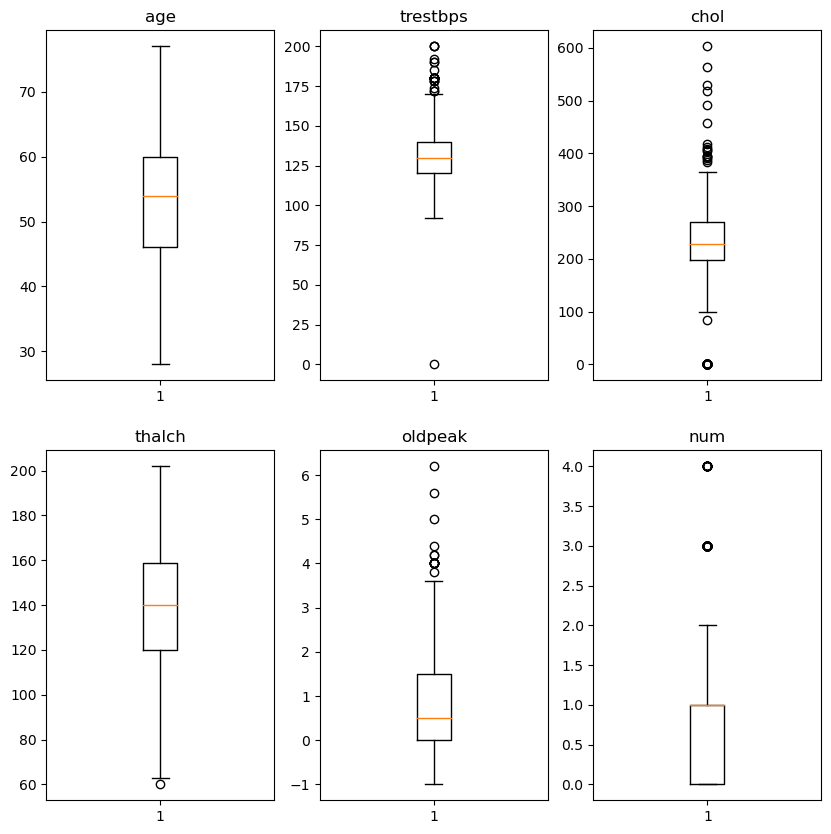

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(10,10))
axs[0, 0].boxplot(X4.age)
axs[0, 0].set_title('age')

axs[0, 1].boxplot(X4.trestbps)
axs[0, 1].set_title('trestbps')

axs[0, 2].boxplot(X4.chol)
axs[0, 2].set_title('chol')

axs[1, 0].boxplot(X4.thalch)
axs[1, 0].set_title('thalch')

axs[1, 1].boxplot(X4.oldpeak)
axs[1, 1].set_title('oldpeak')

axs[1, 2].boxplot(X4.num)
axs[1, 2].set_title('num')

`Oldpeak negativni outlier pretvori u pozitivnu vrijednost (nestao micanjem redaka u kojima su exang i fbs NaN), a trestbps i chol outliere u nuli pretvori u prosječnu vrijednost. Chol gornje outliere ukloni.`

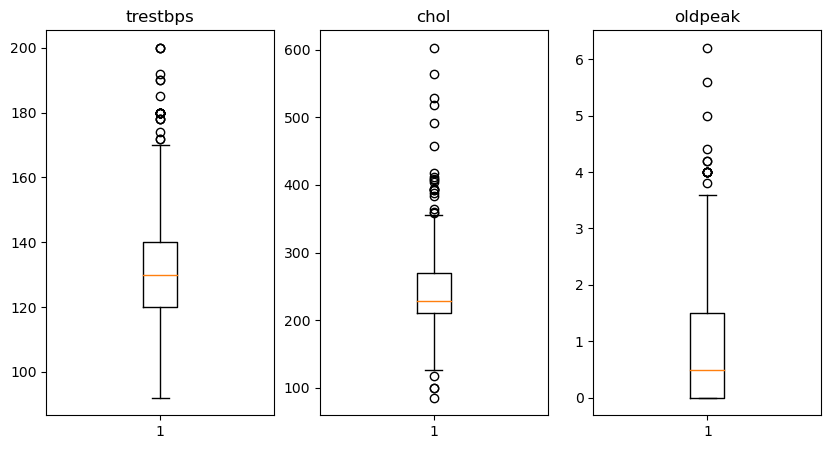

In [16]:
X5 = X4.copy()

X5['oldpeak'] = X5['oldpeak'].abs()
X5['chol']=X5['chol'].replace(0,X5['chol'].mean())
X5['trestbps']=X5['trestbps'].replace(0,X5['trestbps'].mean())

fig, axs = plt.subplots(1, 3, figsize=(10,5))
axs[0].boxplot(X5.trestbps)
axs[0].set_title('trestbps')
axs[1].boxplot(X5.chol)
axs[1].set_title('chol')
axs[2].boxplot(X5.oldpeak)
axs[2].set_title('oldpeak')
plt.show()

In [17]:
X5.shape

(774, 12)

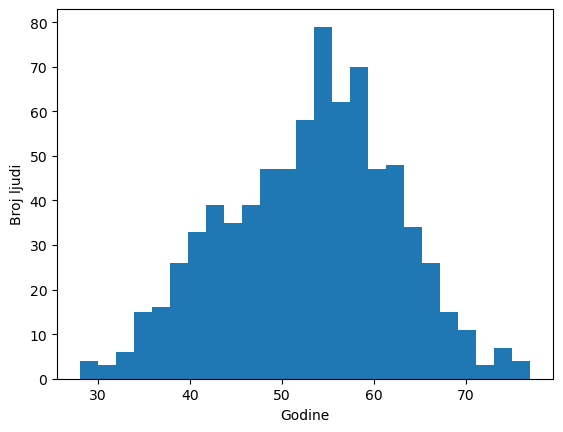

In [18]:
plt.hist(X5.age, bins=25)
plt.xlabel('Godine')
plt.ylabel('Broj ljudi')
plt.show()

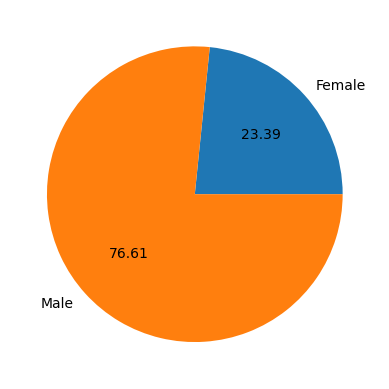

In [19]:
count_per_sex = X5.groupby('sex').count().loc[:,'age'].values
percent = (count_per_sex/len(X5))*100
sex_unique_values = X5.groupby('sex').count().index.values

plt.pie(percent, labels=sex_unique_values, autopct='%.2f')
plt.show()

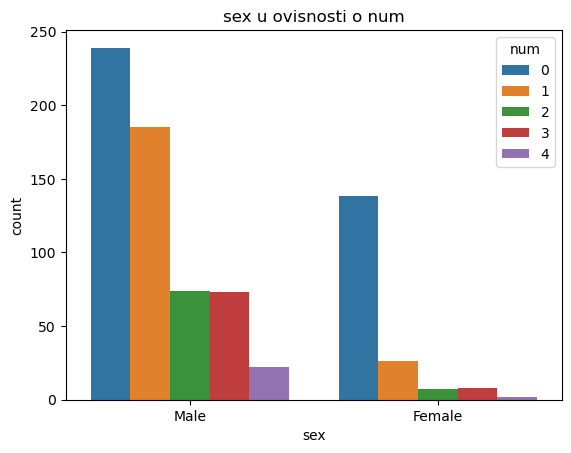

In [20]:
#histogram muskaraca i žena koji imaju bolest i koji nemaju
X5['num'] = X5['num']

sns.countplot(data=X5, x='sex', hue='num')
plt.title('sex u ovisnosti o num')
plt.show()

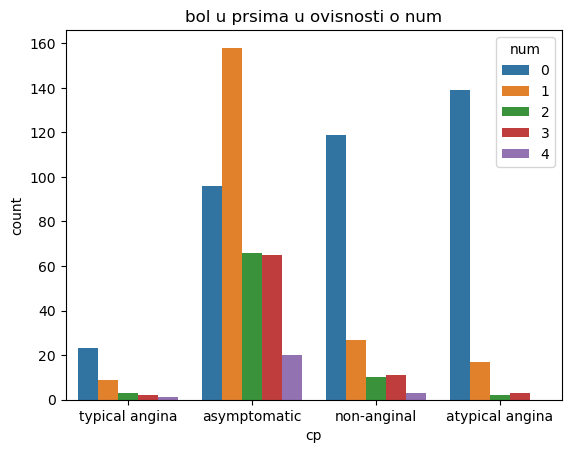

In [21]:
#histogram muskaraca koji imaju bolest i koji nemaju
X5['cp'] = X5['cp']

sns.countplot(data=X5, x='cp', hue='num')
plt.title('bol u prsima u ovisnosti o num')
plt.show()

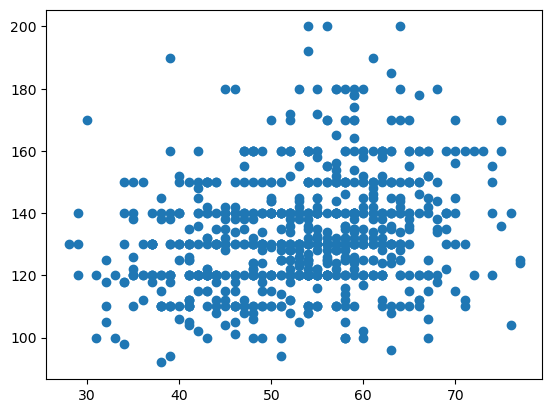

In [22]:
plt.scatter(X5.age, X5.trestbps)
plt.show()

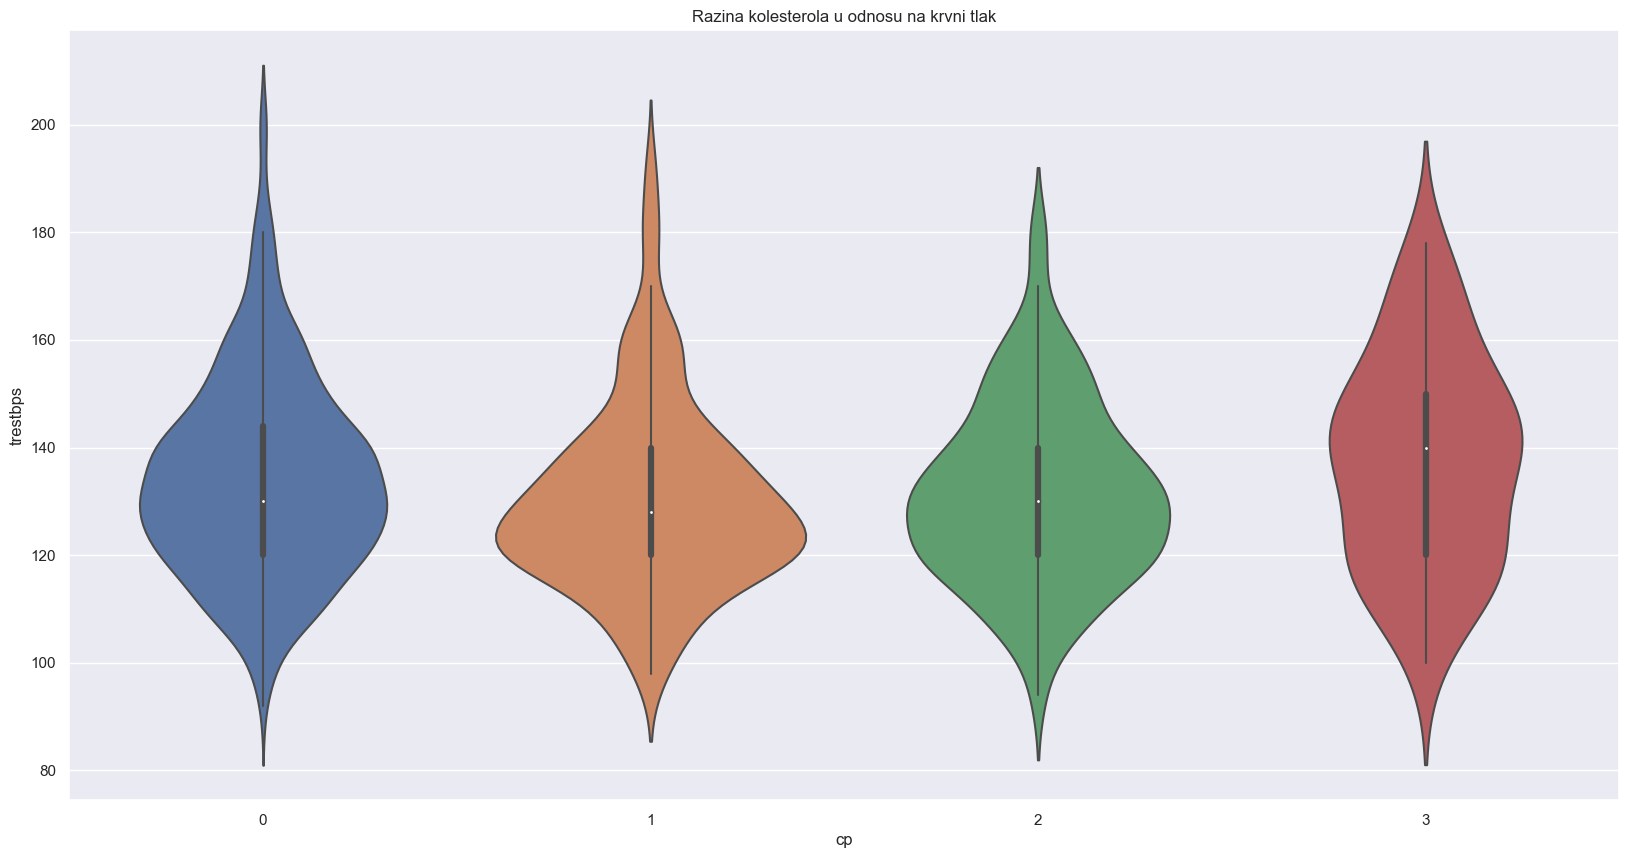

In [34]:
sns.violinplot(data=X5, x='cp', y='trestbps')
plt.title('Razina kolesterola u odnosu na krvni tlak')
plt.show()

### Label Encoder

In [24]:
le = LabelEncoder()
le.fit(X5.loc[:,'sex'])
X5.loc[:,'sex'] = le.transform(X5.loc[:,'sex'])
le.fit(X5.loc[:,'cp'])
X5.loc[:,'cp'] = le.transform(X5.loc[:,'cp'])
le.fit(X5.loc[:,'fbs'])
X5.loc[:,'fbs'] = le.transform(X5.loc[:,'fbs'])
le.fit(X5.loc[:,'restecg'])
X5.loc[:,'restecg'] = le.transform(X5.loc[:,'restecg'])
le.fit(X5.loc[:,'exang'])
X5.loc[:,'exang'] = le.transform(X5.loc[:,'exang'])
le.fit(X5.loc[:,'dataset'])
X5.loc[:,'dataset'] = le.transform(X5.loc[:,'dataset'])

/var/folders/gz/blq0wwnn6bg59fmygpb2zpp80000gn/T/ipykernel_58087/2360912222.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X5.loc[:,'sex'] = le.transform(X5.loc[:,'sex'])
/var/folders/gz/blq0wwnn6bg59fmygpb2zpp80000gn/T/ipykernel_58087/2360912222.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X5.loc[:,'cp'] = le.transform(X5.loc[:,'cp'])
/var/folders/gz/blq0wwnn6bg59fmygpb2zpp80000gn/T/ipykernel_58087/2360912222.py:7: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead 

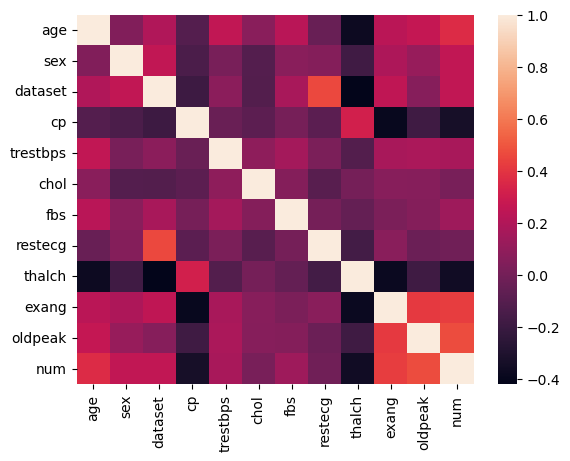

In [25]:
X5_numeric = X5.loc[:,~X5.columns.isin([])]
sns.heatmap(X5_numeric.corr())
plt.show()

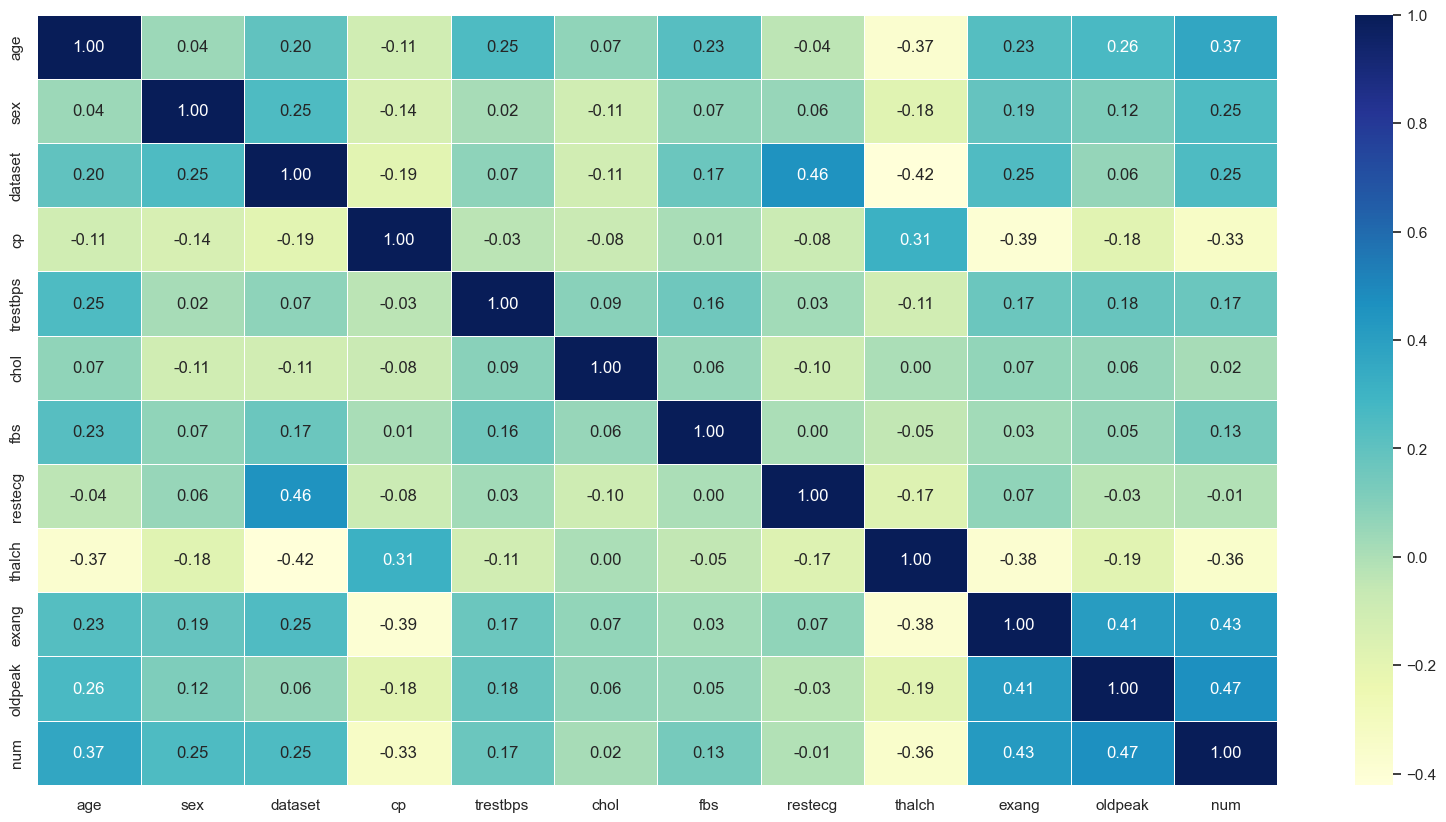

In [26]:
sns.set(rc={'figure.figsize':(20,10)})
sns.heatmap(X5_numeric.corr(), annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.show()

In [27]:
#deskriptivna statistika (bez testova???)
X5.describe(include='all')

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,num
count,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000,774.000000
mean,53.071059,0.766150,1.029716,0.794574,132.955056,241.618085,0.151163,0.936693,138.677003,0.394057,0.891243,0.919897
std,9.430970,0.423552,1.085192,0.947754,17.951735,54.652612,0.358439,0.624943,25.808812,0.488963,1.078337,1.133424
min,28.000000,0.000000,0.000000,0.000000,92.000000,85.000000,0.000000,0.000000,60.000000,0.000000,0.000000,0.000000
25%,46.000000,1.000000,0.000000,0.000000,120.000000,210.000000,0.000000,1.000000,120.000000,0.000000,0.000000,0.000000
50%,54.000000,1.000000,1.000000,0.000000,130.000000,228.000000,0.000000,1.000000,140.000000,0.000000,0.500000,1.000000
75%,60.000000,1.000000,1.000000,2.000000,140.000000,269.000000,0.000000,1.000000,159.000000,1.000000,1.500000,1.000000
max,77.000000,1.000000,3.000000,3.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,4.000000


In [28]:
X5['chol'].mean()

241.61808504917394

In [29]:
X5['chol'].median()

228.0

In [30]:
X5['chol'].mode()

0    218.472427
Name: chol, dtype: float64

In [31]:
X5['chol'].std()

54.652612430622376

In [32]:
X5['chol'].var()

2986.90804549182